# 3 Teoría de la estimación
## 3.3 Prueba de hipótesis lineal (regresión lineal)

<p align="right">
Autor: Emmanuel Alcalá
<br>
<a href="https://scholar.google.com.mx/citations?hl=en&user=3URusCgAAAAJ&view_op=list_works&sortby=pubdate">Google Scholar</a>
</p>

<p align="left">
<br>
<a href="https://jealcalat.github.io/Analisis_multivariado/">Regresar a la página del curso</a>
</p>

---

La hipótesis lineal es un concepto estadístico que establece que la media (promedio) de una observación aleatoria se puede escribir como una combinación lineal de algunas variables predictoras observadas. Por ejemplo, si tenemos una variable dependiente $y$ y variables predictoras $x_1$, una hipótesis lineal establecería que para algunos números desconocidos (parámetros) $\beta_0, \beta_1$:

$$y = \beta_0 + \beta_1 x + \epsilon$$

donde $y$ es la variable de respuesta (resultado, variable predicha, etc), $x$ es la variable predictora, $\beta_0$ es la intersección, $\beta_1$ es la pendiente y $\epsilon$ es el término de error. La hipótesis lineal prueba si el coeficiente de pendiente $\beta_1$ es significativamente diferente de cero, lo que indica que existe una relación lineal entre el predictor y las variables de resultado.

Asumiendo que $\epsilon$ sigue una distribución normal con media de 0 y desviación estándar $\sigma$, tomando la esperanza de ambos lados de la ecuación da:

$$\text{E}(y) = \text{E}(\beta_0 + \beta_1 x + \epsilon)$$

Por linealidad de la expectativa, podemos escribir:

$$\text{E}(y) = \text{E}(\beta_0) + \text{E}(\beta_1 x) + \text{E}(\epsilon)$$

Dado que $\beta_0$ y $\beta_1$ son constantes, podemos tratarlos como valores conocidos y sus expectativas son simplemente sus valores:

$\text{E}(y) = \beta_0 + \beta_1 \text{E}(x) + \text{E}(\epsilon)$

Dado que asumimos que el término de error $\epsilon$ tiene una distribución normal con media cero, sabemos que $\text{E}(\epsilon) = 0$. Por lo tanto, podemos simplificar la ecuación a:

$\text{E}(y) = \beta_0 + \beta_1 \text{E}(x)$

Esta ecuación representa el valor esperado de la variable de resultado $y$, dado un valor específico de la variable predictora $x$. Muestra que el valor esperado de $y$ es una función lineal de $x$, con intersección $\beta_0$ y pendiente $\beta_1$.

Tener en cuenta que esta ecuación asume que la variable predictora $x$ es fija y no aleatoria. Si $x$ es una variable aleatoria, necesitaríamos tomar la expectativa de ambos lados de la ecuación usando la distribución apropiada de $x$.

In [70]:
# %% Import libraries
from sklearn.linear_model import LinearRegression  # minimos cuadrados
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize  # para minimizar -log-vero
import statsmodels.api as sm
import pandas as pd

El modelo lineal es de la forma

$$
  y = \beta_0 + \beta_1 x
$$

Considerar que el anterior modelo es el proceso generador. Con datos observados, asumimos que el modelo tiene un error de medición $\epsilon_i$

$$
  y_1 = \beta_0 + \beta_1 x_i + \epsilon_i,\quad \text{ con } \epsilon_i \sim \text{Normal}(0, \sigma)
$$

la asunción de que los errores se distribuyen según una variable aleatoria normal con media de 0 y desviación estándar $\sigma$ nos permite usar el método de MLE para obtener estimadores de los parámetros $\beta_0$ y $\beta_1$. Si

$$
  \epsilon_i \sim \text{Normal}(0, \sigma)
$$

y

$$
  \epsilon_i = y_i - (\beta_0 + \beta_1 x_i)
$$

Entonces

$$
  y_i - (\beta_0 + \beta_1 x_i) \sim \text{Normal}(0, \sigma)
$$


In [71]:

# Define the linear model

def linear_model(x, b0, b1):
    # The linear model takes the x values, and returns the predicted y values
    # It does this by multiplying the slope by the x value and adding it to the intercept
    return b0 + b1 * x

def neg_log_likelihood(params, x):
    # assign the parameters
    # The parameters are the slope, intercept, and sigma
    intercept = params[0]
    slope = params[1]
    sigma = params[2]

    # Compute the predicted values
    # The predicted values are the y values that the linear model predicts
    y_pred = linear_model(x, intercept, slope)

    # Compute the negative log-likelihood of the normal.
    # beware we're using the log transformation of the normal
    # The negative log-likelihood of the normal is the negative log of the normal distribution
    nll = -np.sum(np.log(1 / (np.sqrt(2 * np.pi) * sigma)) -
                  0.5 * ((y - y_pred) / sigma)**2)

    return nll


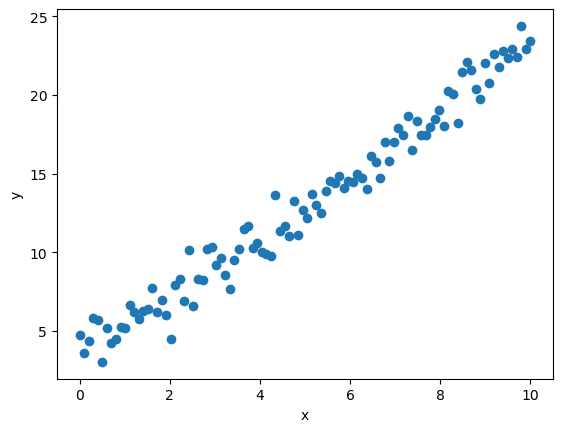

In [72]:
# Generate some data for simple linear regression
np.random.seed(0)
num_samples = 100
x = np.linspace(0, 10, num_samples)
sigma = 1
b0_real = 3
b1_real = 2
epsilon = np.random.normal(0, sigma, num_samples)
y = b0_real + b1_real * x + epsilon

# Plot the data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [73]:
# Initialize parameters
b0 = 0  # valores iniciales para la funcion minimze
b1 = 0
sigma = 1

# Run the minimization algorithm
# segungo argumento de minimize son los parametros iniciales

result = minimize(neg_log_likelihood, [b0, b1, sigma], args=(x,),
                  method='Nelder-Mead',
                  bounds=[(None, None), (None, None), (0, None)])

residuales = y - result.x[1] - result.x[0] * x

# Print the optimal parameters and the minimum negative log-likelihood
print("Estimates: ")
print("----------------------------")
print("Intercept: %0.2f\nSlope: %0.2f\nSigma: %0.2f\nMean of epsilon_hat: %0.6f" %
      (result.x[0], result.x[1], result.x[2], np.mean(residuales)))

Estimates: 
----------------------------
Intercept: 3.21
Slope: 1.97
Sigma: 1.00
Mean of epsilon_hat: -4.952848


## Inferencia sobre los parámetros

Ahora veremos cómo estimar la variabilidad y poder hacer algunas inferencias sobre ello. Usualmente, estos valores se obtienen asumiendo una distribución específica. En jerga estadística, se diría que una distribución límite. Sin embargo, podemos usar un método no paramétrico llamado bootstrapping para estimar la variabilidad de los parámetros.

Pero primero, ¿por qué es necesario estimar la variabilidad?  Por lo siguiente:

Con base en una sola muestra, podemos ver en la simulación anterior que los valores *reales* (que podemos decir que son los valores de la población) son cercanos, pero no idénticos, a los valores estimados.

\begin{align*}
& &\text{ parámetros }\\
&\beta_0 &= 3;\ \beta_1 &= 2\\
&& \text{ estimadores }\\ 
&\hat{\beta_0} &= 3.21;\ \hat{\beta_1} &= 1.97
\end{align*}

Este *error* se considera un error de muestreo. Si repitiéramos el proceso de tomar una muestra, ajustar el modelo, obtener los parámetros, volver a tomar una muestra, etc., obtendríamos una distribución de los estimadores (llamada, justamente, la distribución muestral del estimador). Si repetimos el proceso un número de veces muy grande, la media de la distribución muestral del estimador es igual al estimador del parámetro.

In [74]:
# simularemos el proceso de obtener n_sims muestras de la población, y
# por cada muestra obtendremos los estimadores. Solo para mostrar el concepto
# guardaremos únicamente el slope y obtendremos su media
n_sims = 500

slopes = []
for i in range(n_sims):
  # Generar una muestra
  num_samples = 100
  x = np.linspace(0, 10, num_samples)
  sigma = 1
  b0_real = 3
  b1_real = 2
  epsilon = np.random.normal(0, sigma, num_samples)
  y = b0_real + b1_real * x + epsilon
  # obtener los parámetros
  b0 = 0  # valores iniciales para la funcion minimze
  b1 = 0
  sigma = 1
  result = minimize(neg_log_likelihood, [b0, b1, sigma], args=(x,),
                    method='Nelder-Mead',
                    bounds=[(None, None), (None, None), (0, None)])

  slopes.append(result.x[1])

# la media debe ser más próxima al parámetro real
np.mean(slopes)

/tmp/ipykernel_1524991/2592438919.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  nll = -np.sum(np.log(1 / (np.sqrt(2 * np.pi) * sigma)) -
/tmp/ipykernel_1524991/2592438919.py:23: RuntimeWarning: divide by zero encountered in true_divide
  0.5 * ((y - y_pred) / sigma)**2)
/tmp/ipykernel_1524991/2592438919.py:22: RuntimeWarning: invalid value encountered in subtract
  nll = -np.sum(np.log(1 / (np.sqrt(2 * np.pi) * sigma)) -


2.003600888040519

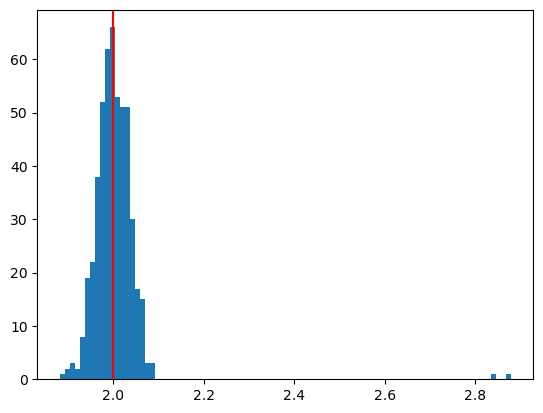

In [75]:
# podemos obtener un histograma de las medias para visualizar qué tan frecuentemente
# encontramos un estimador próximo al estimador real
plt.hist(slopes, bins=90);
plt.axvline(x=b1_real, c='r')

El anterior proceso nos permite entender que la estimación de parámetros no sucede sin errores. Por lo tanto, existe cierta incertidumbre, que llamamos variabilidad en la estimación.

Los métodos usuales para estimar la variabilidad se basan en teoría asintótica, la teoría estadística que nos permite aproximar una distribución con, por ejemplo, una distribución normal. Según esta teoría asintótica, el error estándar. En el contexto de la regresión lineal simple, el error estándar mide la precisión del coeficiente de pendiente estimado. Refleja el grado de variabilidad de las estimaciones de pendiente que se obtendrían si el mismo modelo de regresión se ajustara a diferentes muestras de la misma población. Usualmente se computa con la siguiente fórmula

$$
  SE(\hat{\beta}_1) = \sqrt{ (MSE) / ((n-1) * Var(x)) }
$$

La derivación de esta fórmula se basa en la suposición de que los errores (es decir, las diferencias entre los valores observados de la variable de resultado y los valores pronosticados según el modelo de regresión) se distribuyen normalmente con media cero y varianza constante (es decir, homocedasticidad). Bajo estos supuestos, el estimador de la pendiente es un estimador insesgado de la pendiente verdadera, y su distribución muestral se aproxima a una distribución normal a medida que aumenta el tamaño de la muestra.

El error estándar se puede usar para obtener estimadores del intervalo de confianza. Un intervalo de confianza para la pendiente en una regresión lineal simple es un rango de valores plausibles para la pendiente real en función de la pendiente estimada y su error estándar. Proporciona una medida de la incertidumbre asociada con la estimación de la pendiente y puede ayudarnos a determinar si la relación entre el predictor y las variables de resultado es estadísticamente significativa.

Un intervalo de confianza al $(1-\alpha)$ de probabilidad se calcula sobre un rango de valores. Por ejemplo, si tenemos el rango $[a,b]$, un IC al 95% es un rango tal que la probabilidad de encontrar el valor real del parámetro es del 0.95, es decir

$$
  p(\beta_1 \in [a, b]) = 0.95
$$



Tomar en cuenta que si no se cumplen los supuestos de normalidad y homocedasticidad, es posible que el error estándar no sea preciso y que se utilicen métodos alternativos, como el bootstrapping, para estimar el error estándar. 

Bootstrapping es una técnica estadística para estimar la variabilidad de un estadístico (como la media o el error estándar) mediante el remuestreo de los datos originales. Es un método no paramétrico que no se basa en hacer suposiciones sobre la distribución subyacente de los datos.
En bootstrapping, creamos una gran cantidad de remuestreos mediante muestreo aleatorio del conjunto de datos original con reemplazo. Luego calculamos la estadística de interés (por ejemplo, la media o el error estándar) para cada nueva muestra y usamos la distribución resultante de estas estadísticas para estimar la variabilidad de la estadística.

Usaremos esta técnica para estimar el el error estándar, luego también un intervalo de confianza e inferir algo sobre la pendiente. También usaremos la hipótesis nula de que la pendiente es cero para probar si la pendiente es estadísticamente significativa (una pendiente de 0 significa que no existe una relación lineal entre las variables $x, y$). Para esto, restaremos la media de la distribución de los coeficientes de pendiente obtenidos mediante la técnica de bootstrapping, esto nos dará una distribución centrada en cero, que llamaremos la distribución nula de los coeficientes de pendiente. Esto es así porque se espera que, bajo la hipótesis nula, la pendiente debería tener su centro en 0.

Luego, calcularemos el valor $p$ para la pendiente estimada, que es la probabilidad (que aquí obtenemos como la proporción de casos) de obtener un valor tan grande o más grande de la pendiente estimada bajo la hipótesis nula de que la pendiente es cero. 

$H_0: \beta = 0$

Si el valor $p$ es menor que el nivel de significancia, podemos rechazar la hipótesis nula de que la pendiente es cero y concluir que la pendiente es estadísticamente significativa. En otras palabras, estimamos la probabilidad de que la pendiente sea 0 *bajo la hipótesis nula*. Si esta probabilidad es muy baja, tenemos evidencia de que la pendiente no es 0. Definiendo un umbral de decisión (e.g., 0.05), decidimos que la pendiente es estadísticamente significativa si el valor $p$ es menor que el umbral de decisión, es decir, si $p$ < 0.05.

En estadística, el nivel de significación (a menudo denominado $\alpha$) es un umbral que se utiliza para determinar si los resultados de una prueba estadística o un intervalo de confianza son estadísticamente significativos o no.


In [76]:
# Este código realiza una regresión lineal en un conjunto de datos y luego realiza un remuestreo con bootstrapping en los datos para encontrar un valor p para la pendiente de regresión.
# El código usa una función para realizar el remuestreo y la regresión.
# La función se llama en un bucle for para realizar 1000 remuestreos.
# Las pendientes de las nuevas muestras se trazan en un histograma.
# El valor p se calcula dividiendo el número de pendientes que son mayores que la pendiente real o menores que la pendiente real entre el número total de pendientes.
# El error estándar de la pendiente se calcula tomando la desviación estándar de las pendientes.
# El intervalo de confianza del 95% de la pendiente se calcula tomando los percentiles de las pendientes.

from sklearn.linear_model import LinearRegression
np.random.seed(0)
num_samples = 100
x = np.linspace(0, 10, num_samples)
sigma = 1
b0_real = 3
b1_real = 2
# probar con una distribución exponencial con lambda = 5
# en principio, incluso si el error no es normal, el método de bootstrapping
# debería funcionar
epsilon = np.random.exponential(5, num_samples)
y = b0_real + b1_real * x + epsilon


# fit a simple linear regression model
model = LinearRegression()
# ajuster el modelo, con reshape(-1, 1) se ajusta a un array 2D de 1 columna
model.fit(x.reshape(-1, 1), y)
residuales = y - model.predict(x.reshape(-1, 1))
# Define a function to perform bootstrap resampling and fit a regression model
def bootstrap_regression(data):
    sample = data.sample(frac=1, replace=True)
    X = sample[['x']]
    y = sample['y']
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

# Resample the data and compute the p-value
data = pd.DataFrame({'x': x, 'y': y})
n_bootstraps = 1500 # R
slopes = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    slopes[i] = bootstrap_regression(data)

# obtain the null distribution of slopes, centered at 0
null_slopes = slopes - np.mean(slopes)
# calculate the p-value as the proportion of null slopes that are greater than or 
# less than the actual slope, which we obtained with the original data
p_value = (np.sum(null_slopes >= model.coef_[0]) + np.sum(null_slopes <= -model.coef_[0])) / len(null_slopes)

beta_1_hat = result.x[1]
se = np.std(slopes)
print('Standard error of slope:', se.round(2))

# calculate the 95% confidence interval of the slope
ci = np.percentile(slopes, [2.5, 97.5])
print('95% confidence interval of slope:', ci.round(2))
print('P-value of the slope:', p_value)

Standard error of slope: 0.15
95% confidence interval of slope: [1.41 1.99]
P-value of the slope: 0.0


El intervalo de confianza *paramétrico*, es decir, asumiendo que los errores se distribuyen normalmente, se puede obtener estimando el error estándar como se mencionó antes. Se calcularía como

$$
  \hat{\beta}_1 \pm t_{n-2, 1-\alpha/2} * SE(\hat{\beta}_1)
$$

En donde $t_{n-2, 1-\alpha/2}$ es el valor crítico de la distribución t de Student con $n-2$ grados de libertad y un nivel de significancia de $\alpha/2$. Se usan los grados de libertad $n-2$ porque se estima la pendiente y la intersección con el eje $y$.

En Python, el valor crítico se puede obtener con la función `stats.t.ppf` de la librería `scipy.stats`.
```python
from scipy.stats import t

t.ppf(1-0.025, df=n-2)
```

El error estándar de la pendiente estimada se puede obtener con la función `stats.linregress` de la librería `scipy.stats`.
```python
from scipy.stats import linregress
linregress(x, y).stderr
```

O bien, usando el MSE y la varianza de $x$.
```python
np.sqrt(MSE / ((n-1) * np.var(x)))
```

Y el MSE se obtiene con los residuales.
```python
residuals = y - y_pred
MSE = np.mean(residuals**2)
```

La prueba de normalidad para los residuales se puede hacer con la función `stats.normaltest` de la librería `scipy.stats`.
```python
from scipy.stats import normaltest
normaltest(residuals)
```

Si el valor p de la prueba de normalidad es menor que el nivel de significancia, se rechaza la hipótesis nula de que los residuales se distribuyen normalmente. Es decir, los residuales no se distribuyen normalmente. Sabemos que esto es así porque simulamos el error epsilon con una distribución exponencial.

In [77]:
from scipy.stats import normaltest
from scipy.stats import t
from scipy.stats import linregress

# num_samples es el número de observaciones en la muestra en nuestra anterior
# simulación
num_samples = 100

t_crit = t.ppf(1-0.025, df=num_samples-2)
MSE = np.sum(residuales**2) / (num_samples - 2)
se_b1 = np.sqrt(MSE / np.sum((x - np.mean(x))**2))
# calculamos los límites del intervalo de confianza
ci_95 = [beta_1_hat - t_crit * se_b1, beta_1_hat + t_crit * se_b1]
print('95% confidence interval of slope:', np.round(ci_95,2))
print("se_b1 manual: ", se_b1.round(2))
print("se con linregress: ", linregress(x, y)[4].round(2))
print('P-value of the normality test:', normaltest(residuales)[1].round(6))

95% confidence interval of slope: [1.68 2.31]
se_b1 manual:  0.16
se con linregress:  0.16
P-value of the normality test: 0.0


Notar que el intervalo de confianza paramétrico es diferente al intervalo no paramétrico.

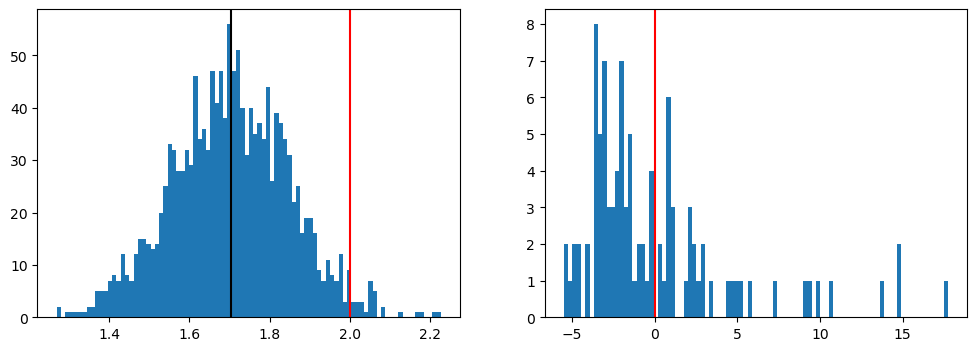

In [78]:
# haremos un gráfico de dos paneles con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(slopes, bins=90);
ax1.axvline(x=b1_real, c='r')
ax1.axvline(model.coef_[0], 0, c='k')
ax2.hist(residuales, bins=90);
ax2.axvline(np.mean(residuales), c='r')

Si el intervalo de confianza no contiene al 0, podemos concluir que la hipótesis nula es falsa.

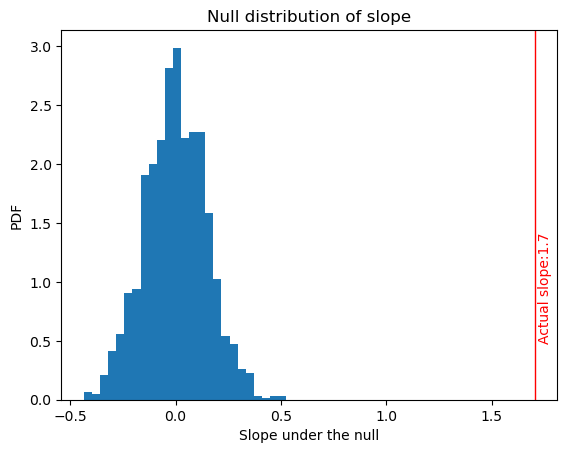

In [79]:
# function that plots the null distribution and the actual slope on the histogram 
def plot_null_distribution(slopes, slope):
    # generate a histogram of the null distribution 
    plt.hist(slopes, bins=25, density=True)
    
    # plot the actual slope on the histogram 
    plt.axvline(x=slope, color='red', linewidth=1)
    
    # label the axes and show the plot 
    plt.xlabel('Slope under the null')
    plt.ylabel('PDF')
    plt.title('Null distribution of slope')
    # put a label on the actual slope
    plt.text(slope*1.01, 0.5, f'Actual slope:{model.coef_[0].round(2)}', rotation=90, color='red')
    plt.show()
    
plot_null_distribution(null_slopes, model.coef_[0])


En el gráfico anterior, podemos ver que el verdadero valor de la pendiente está muy alejado del centro de la distribución nula. Es decir, bajo la hipótesis nula de que la pendiente es cero, *es muy raro* observar un valor como el observado. 



Para el error estándar, su valor es simplemente la desviación estándar de las pendientes obtenidas por remuestreo.

Para el intervalo de confianza, calculamos los percentiles 2.5 y 97.5 de la distribución resultante de los coeficientes de pendiente para obtener el intervalo de confianza del 95 % para la pendiente. Si el intervalo *no contiene al 0*, se puede inferir que la pendiente no es 0 al 95% de confianza.

## Regresión lineal múltiple

La regresión lineal múltiple es una extensión de la regresión lineal simple. En lugar de ajustar una línea recta a los datos, ajustamos una hiperplano. En la regresión lineal múltiple, la variable de respuesta es continua y hay más de una variable predictora. En vez de la pendiente, tenemos una matriz de coeficientes de pendiente, y en vez de la intersección, tenemos un término de intersección. La forma general del modelo es:

$$
  y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p + \epsilon
$$

en donde $y$ es la variable dependiente, $x_1, x_2, \dots, x_p$ son las variables independientes, $\beta_0, \beta_1, \beta_2, \dots, \beta_p$ son los coeficientes del modelo (también conocidos como pesos o parámetros de regresión), y $\epsilon$ es el término de error (también conocido como residual).

El objetivo de la regresión lineal múltiple es estimar los valores de los coeficientes $\beta_0, \beta_1, \beta_2, \dots, \beta_p$ que mejor se ajustan a los datos, minimizando la suma de los errores cuadráticos entre los valores predichos y los valores reales de los dependientes. variable. Normalmente, esto se realiza mediante un método como el de mínimos cuadrados ordinarios (OLS) o la estimación de máxima verosimilitud (MLE).

Para determinar qué predictores incluir en el modelo, se pueden utilizar métodos como la regresión por pasos o técnicas de regularización como la regresión de cresta o la regresión de lazo. Además, para evaluar el rendimiento del modelo, se pueden utilizar métricas como el error cuadrático medio o el coeficiente de determinación $R^2$.

In [80]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
  

california_housing = fetch_california_housing(as_frame=True)
# california_housing es un diccionario con las siguientes claves:
print(california_housing.frame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


In [81]:
# asignamos a X las variables explicativas y a y la variable dependiente
X = california_housing.data
y = california_housing.target
# Print summary statistics of the dataset

# y as dataframe
y = pd.DataFrame(y)
display_side_by_side(X.describe(), y.describe(), titles=['Caracteristicas', 'Target'])


Caracteristicas 
 
 
 
 MedInc 
 HouseAge 
 AveRooms 
 AveBedrms 
 Population 
 AveOccup 
 Latitude 
 Longitude 
 
 
 
 
 count 
 20640.000000 
 20640.000000 
 20640.000000 
 20640.000000 
 20640.000000 
 20640.000000 
 20640.000000 
 20640.000000 
 
 
 mean 
 3.870671 
 28.639486 
 5.429000 
 1.096675 
 1425.476744 
 3.070655 
 35.631861 
 -119.569704 
 
 
 std 
 1.899822 
 12.585558 
 2.474173 
 0.473911 
 1132.462122 
 10.386050 
 2.135952 
 2.003532 
 
 
 min 
 0.499900 
 1.000000 
 0.846154 
 0.333333 
 3.000000 
 0.692308 
 32.540000 
 -124.350000 
 
 
 25% 
 2.563400 
 18.000000 
 4.440716 
 1.006079 
 787.000000 
 2.429741 
 33.930000 
 -121.800000 
 
 
 50% 
 3.534800 
 29.000000 
 5.229129 
 1.048780 
 1166.000000 
 2.818116 
 34.260000 
 -118.490000 
 
 
 75% 
 4.743250 
 37.000000 
 6.052381 
 1.099526 
 1725.000000 
 3.282261 
 37.710000 
 -118.010000 
 
 
 max 
 15.000100 
 52.000000 
 141.909091 
 34.066667 
 35682.000000 
 1243.333333 
 41.950000 
 -114.310000 
 
 
 Target 
 
 
 
 MedHouseVal 
 
 
 
 
 count 
 20640.000000 
 
 
 mean 
 2.068558 
 
 
 std 
 1.153956 
 
 
 min 
 0.149990 
 
 
 25% 
 1.196000 
 
 
 50% 
 1.797000 
 
 
 75% 
 2.647250 
 
 
 max 
 5.000010

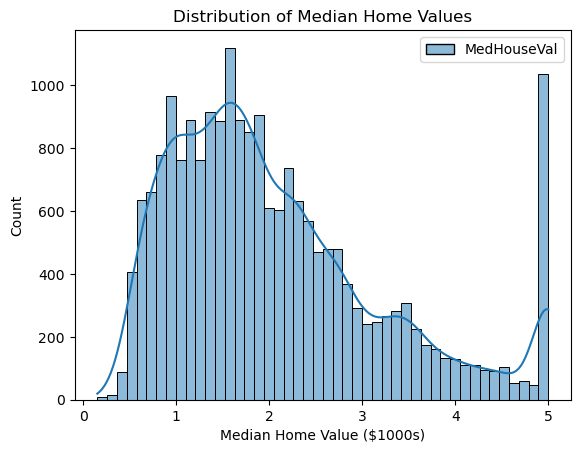

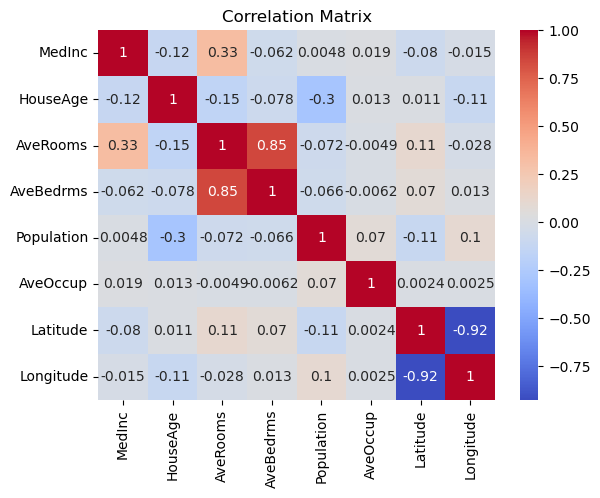

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)


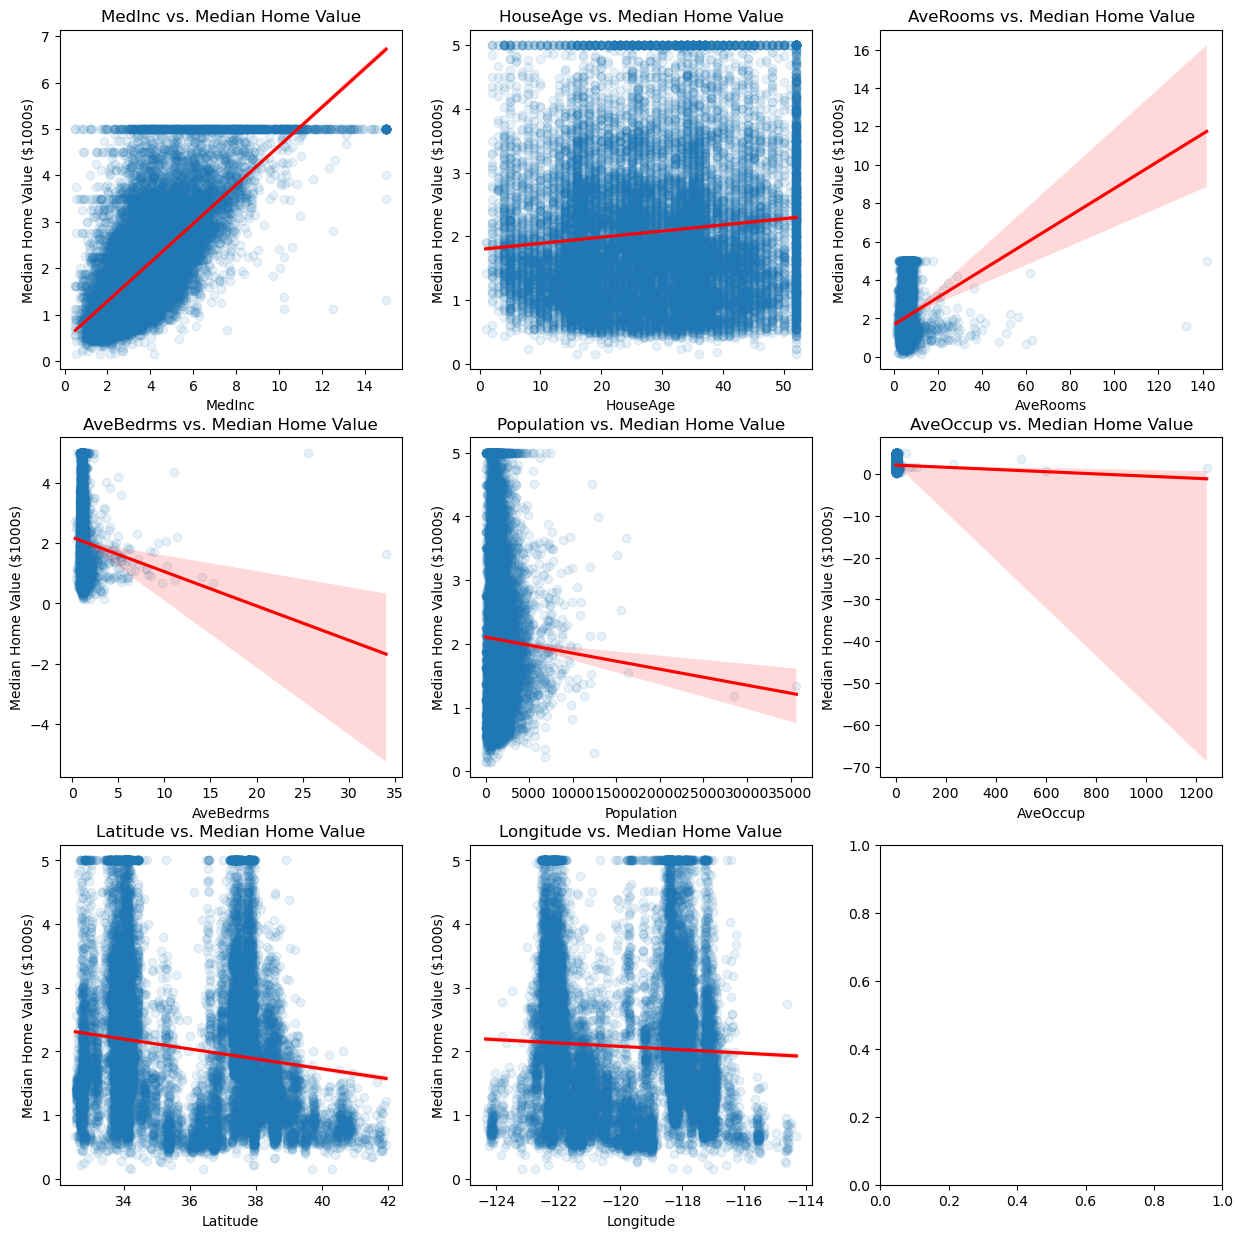

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Visualize the distribution of the target variable
sns.histplot(y, kde=True)
plt.title('Distribution of Median Home Values')
plt.xlabel('Median Home Value ($1000s)')
plt.show()

# Visualize the correlation between the features and the target variable
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

# Visualize the relationship between the features and the target variable
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, feature in enumerate(X.columns):
    ax = axes[i // 3, i % 3]
    print(f'{i // 3, i % 3}')
    sns.regplot(x=X[feature], y=y, ax=ax, scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})
    ax.set_title(f'{feature} vs. Median Home Value')
    ax.set_xlabel(feature)
    ax.set_ylabel('Median Home Value ($1000s)')


plt.show()

In [83]:
# Create linear regression model
model = LinearRegression()

# Compute cross-validation score
scores = cross_val_score(model, california_housing.data, california_housing.target, cv=5, scoring='neg_mean_squared_error')

# Compute mean squared error
mse = -np.mean(scores)
print(f"Mean squared error: {mse}")


Mean squared error: 0.558290171768654


### Comparación de modelos

In [84]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [95]:
# Fit different linear regression models to the data
model1 = LinearRegression().fit(X.iloc[:, [0, 1, 2]], y)
model2 = LinearRegression().fit(X.iloc[:, [3, 4, 5]], y)
model3 = LinearRegression().fit(X.iloc[:, [6, 7, 1]], y)
model4 = LinearRegression().fit(X, y)

# Compute AIC and BIC for each model
aic1 = 2*3 - 2*sm.OLS(y, sm.add_constant(X.iloc[:, [0, 1, 2]])).fit().llf
bic1 = 3*np.log(len(y)) - 2*sm.OLS(y, sm.add_constant(X.iloc[:, [0, 1, 2]])).fit().llf

aic2 = 2*3 - 2*sm.OLS(y, sm.add_constant(X.iloc[:, [3, 4, 5]])).fit().llf
bic2 = 3*np.log(len(y)) - 2*sm.OLS(y, sm.add_constant(X.iloc[:, [3, 4, 5]])).fit().llf

aic3 = 2*3 - 2*sm.OLS(y, sm.add_constant(X.iloc[:, [6, 7, 1]])).fit().llf
bic3 = 3*np.log(len(y)) - 2*sm.OLS(y, sm.add_constant(X.iloc[:, [6, 7, 1]])).fit().llf

aic4 = 2*8 - 2*sm.OLS(y, sm.add_constant(X)).fit().llf
bic4 = 8*np.log(len(y)) - 2*sm.OLS(y, sm.add_constant(X)).fit().llf

# Print AIC and BIC for each model
print(f"Model 1 AIC: {aic1:.2f}, BIC: {bic1:.2f}")
print(f"Model 2 AIC: {aic2:.2f}, BIC: {bic2:.2f}")
print(f"Model 3 AIC: {aic3:.2f}, BIC: {bic3:.2f}")
print(f"Model 4 AIC: {aic4:.2f}, BIC: {bic4:.2f}")
print(f"Model 4 AIC: {aic4:.2f}, BIC: {bic4:.2f}")


Model 1 AIC: 49677.65, BIC: 49701.46
Model 2 AIC: 64418.71, BIC: 64442.51
Model 3 AIC: 58754.20, BIC: 58778.00
Model 4 AIC: 45263.54, BIC: 45327.02
Model 4 AIC: 45263.54, BIC: 45327.02


In [96]:
# sort the AIC and BIC values from lowest to highest
aic = dict(zip(['model1', 'model2', 'model3'], [aic1, aic2, aic3, aic4]))
sorted_aic = sorted(aic.items(), key=lambda x: x[1])
bic = dict(zip(['model1', 'model2', 'model3'], [bic1, bic2, bic3, bic4]))
sorted_bic = sorted(bic.items(), key=lambda x: x[1])
print(f'---------------------')
print(f"Model with lowest AIC: {sorted_aic[0][0]}, AIC: {sorted_aic[0][1]:.2f}")
print(f"Model with lowest BIC: {sorted_bic[0][0]}, BIC: {sorted_bic[0][1]:.2f}")

---------------------
Model with lowest AIC: model1, AIC: 49677.65
Model with lowest BIC: model1, BIC: 49701.46


In [99]:
for i, coef in enumerate(model1.coef_[0]):
    print(f"{model1.feature_names_in_[i]}: {coef:.2f}")

MedInc: 0.44
HouseAge: 0.02
AveRooms: -0.03


In [103]:
model1.intercept_

array([0.02040696])

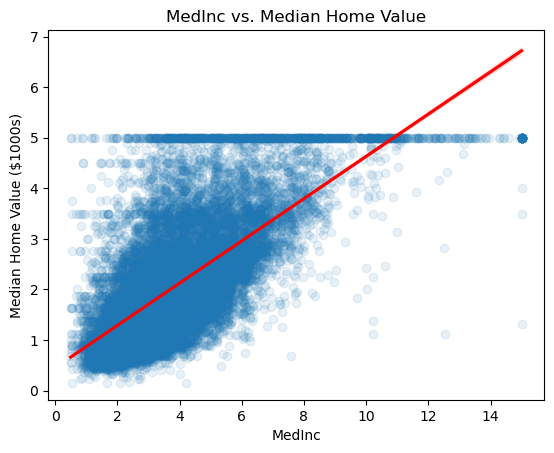

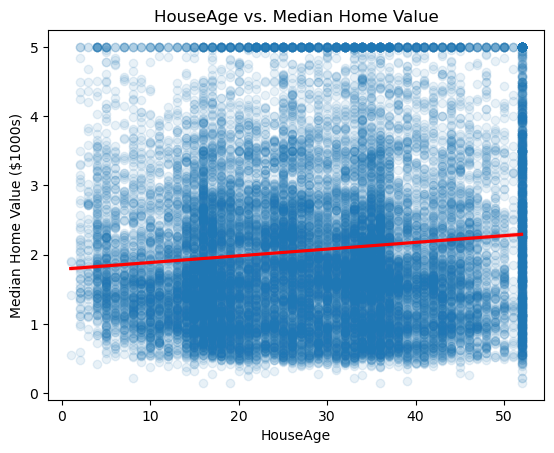

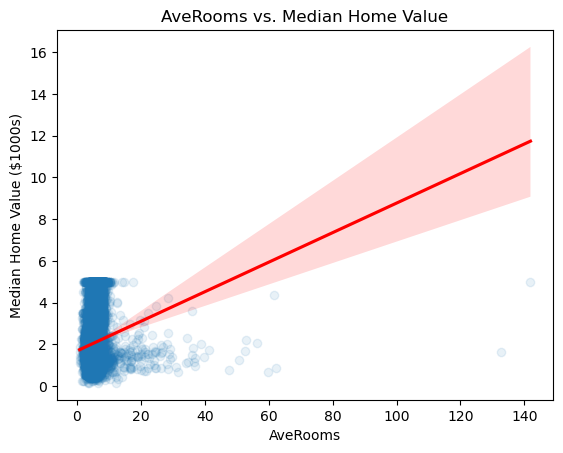

In [101]:
# plot y against the predictors from model 1

for i, feature in enumerate(model1.feature_names_in_):
    plt.figure()
    sns.regplot(x=X[feature], y=y, scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})
    plt.title(f'{feature} vs. Median Home Value')
    plt.xlabel(feature)
    plt.ylabel('Median Home Value ($1000s)')
    plt.show()